In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


### The aim: Predictive model for sales of each product, for the next 6 months
In order to predict sales for the products, we need to know what factors may affect sales and have data to support the assumptions.
The following is a list of several factors that may affect the sales:
1. Holidays. It is well-known that the times before holidays are characterized by *increase* in shopping expenses. Israelis buy more food products before holidays, especially before long holidays (Sukkot, Passover), and holidays during which the market is closed (Rosh HaShana, Yom Kippur, etc).
2. Times of marketing campaigns. During the company's media campaign periods, an elevation in sales is expected, and during the competitor campaign periods, the company might suffer decrease in sales (to be shown using the data below). 
3. Technical reasons, such as production shortage. During shortage times, an expected decrease in sales is inevitable, because the product is simply not on selves. In contrast, after such shortage, there might be increase in sales.
4. Global circumstances. During the time span of the data, a major global (and local) event happened which was the pandemic effect of Covid19. Such events affect sales as costumers were eager to aggregate food and supplies. Same for wars. However, these kind of events are less likely to being forecasted.

To forcast the next 6 months sales, we need to track each product dynamics according to the data in hand. The known parameters we have for the 6 months in advance is only the dates of holidays. In case we also know in advance the dates for marketing campaigns, it will change the prediction accordingly.

In [5]:
# read the data
folder_path = '/Users/mirimichaeli/projects/'
data_file = 'DS_data.xlsx'

sales_data = pd.read_excel(os.path.join(folder_path, data_file), sheet_name='sales') # sales data per each of 6 products from same category
competitor_sales_data = pd.read_excel(os.path.join(folder_path, data_file), sheet_name='competitor_sales') # total sales of the category from competitors 
holidays_data = pd.read_excel(os.path.join(folder_path, data_file), sheet_name='holidays') # dates of holidays 
events_data = pd.read_excel(os.path.join(folder_path, data_file), sheet_name='events') # events (and their dates) that might have affected the sales

### Exploratory data analysis

In [6]:
sales_data.head()

,sales_month,product,sales
0,2020-01-01T00:00:00.000+0000,e,699.861172
1,2020-01-01T00:00:00.000+0000,d,2534.086679
2,2020-01-01T00:00:00.000+0000,f,206.322257
3,2020-01-01T00:00:00.000+0000,b,168.957105
4,2020-01-01T00:00:00.000+0000,c,605.214724


In [7]:
sales_data.isna().sum()

sales_month    0
product        0
sales          0
dtype: int64

In [8]:
sales_data.describe()

,sales
count,233.000000
mean,3396.155000
std,42453.043230
min,-232.175240
25%,128.547848
50%,229.532956
75%,756.519594
max,648518.108095


In [9]:
sales_data[sales_data.sales < 0]

,sales_month,product,sales
60,2021-01-01T00:00:00.000+0000,f,-232.175240
91,2021-06-01T00:00:00.000+0000,f,-183.060787
195,2022-11-01T00:00:00.000+0000,b,-194.223002


##### There are 3 data points that are negative. To my understanding, sales can be 0 or higher. 
##### The meaning of negative sales is not clear to me if it states that this column represents the actual sales during the month
##### and not a relative sales computed in comparison to some other baseline. 
##### So, for the further analyses and model, negative vallues will be replaces by 0

In [10]:
competitor_sales_data.head()

,date,sales
0,2020-01-01,1842.608525
1,2020-02-01,1504.505509
2,2020-03-01,1813.601608
3,2020-04-01,1418.646377
4,2020-05-01,1858.345561


In [11]:
competitor_sales_data.isna().sum()

date     0
sales    0
dtype: int64

In [12]:
competitor_sales_data.describe()

,date,sales
count,42,42.000000
mean,2021-09-15 16:34:17.142857216,1639.106880
min,2020-01-01 00:00:00,1096.035569
25%,2020-11-08 12:00:00,1455.279608
50%,2021-09-16 00:00:00,1620.769638
75%,2022-07-24 06:00:00,1812.000627
max,2023-06-01 00:00:00,2146.484884
std,NaN,241.274031


In [13]:
holidays_data.head()

,date,holiday
0,2020-04-08,Passover I - Eve
1,2020-04-09,Passover I
2,2020-04-10,Passover - Chol HaMoed
3,2020-04-11,Passover - Chol HaMoed
4,2020-04-12,Passover - Chol HaMoed


In [14]:
holidays_data.isna().sum()

date       0
holiday    0
dtype: int64

In [15]:
holidays_data.holiday.unique()

array(['Passover I - Eve', 'Passover I', 'Passover - Chol HaMoed',
       'Passover VII - Eve', 'Passover VII', 'Memorial Day',
       'Independence Day', "Lag B'Omer", 'Shavuot - Eve', 'Shavuot',
       'Rosh Hashanah - Eve', 'Rosh Hashanah', 'Yom Kippur - Eve',
       'Yom Kippur', 'Sukkot I - Eve', 'Sukkot I', 'Sukkot - Chol HaMoed',
       'Sukkot VII - Eve', 'Sukkot VII', 'Hanukkah', 'Purim - Eve',
       'Purim', 'Shushan Purim', 'Memorial Day (Observed)',
       'Independence Day (Observed)'], dtype=object)

In [16]:
events_data.head()

,date,event_name
0,2020-04-01,MediaCampaign
1,2020-04-02,MediaCampaign
2,2020-04-03,MediaCampaign
3,2020-04-04,MediaCampaign
4,2020-04-05,MediaCampaign


In [17]:
events_data.isna().sum()

date          0
event_name    0
dtype: int64

In [18]:
events_data.event_name.unique()

array(['MediaCampaign', 'ProductionShortage', 'CompetitorCampaign',
       'SocialMediaCampaign'], dtype=object)

### Visualizations

##### Total sales over time

In [19]:
sales_data['date'] = sales_data['sales_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%Y-%m-%d'))
sales_data.drop('sales_month', axis=1, inplace=True)
sales_data['date'] = pd.to_datetime(sales_data['date']) # make sure the column is not str
sales_data.head()

,product,sales,date
0,e,699.861172,2020-01-01
1,d,2534.086679,2020-01-01
2,f,206.322257,2020-01-01
3,b,168.957105,2020-01-01
4,c,605.214724,2020-01-01


,date,min,max,mean,std,median
0,2020-01-01,168.957105,2534.086679,842.888387,974.230084,605.214724
1,2020-02-01,159.948954,2262.967384,736.761871,872.201671,528.449292
2,2020-03-01,281.386973,4738.216701,1452.268318,1853.843795,865.735794
3,2020-04-01,167.524937,1434.825761,561.745139,513.628558,444.554236
4,2020-05-01,181.500444,1488.890664,573.541421,535.571980,427.794816
5,2020-06-01,150.190145,1847.280362,661.604399,699.965102,367.633119
6,2020-07-01,142.509373,2027.342671,681.286468,777.007716,439.172250
7,2020-08-01,0.000000,2770.172036,731.203529,1175.070134,187.738606
8,2020-09-01,0.000000,2072.758060,670.332384,819.633354,485.175730
9,2020-10-01,178.844234,2128.262055,785.517966,793.772531,656.591576


<Axes: title={'center': 'sales'}, xlabel='date'>

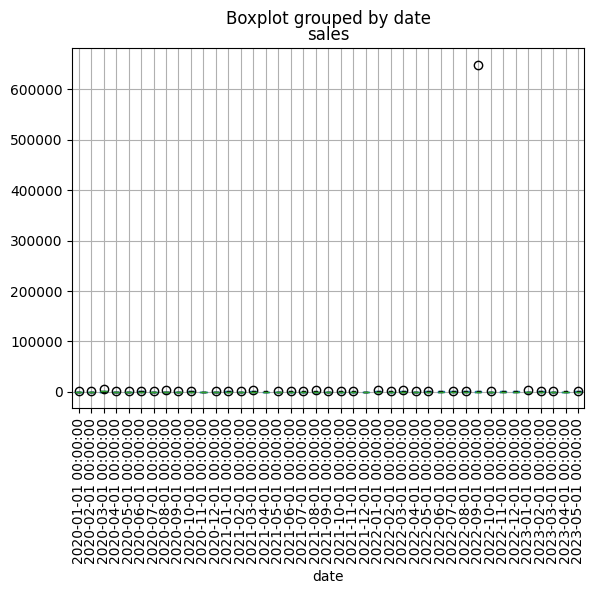

In [27]:
display(sales_data.groupby('date')['sales'].agg(['min', 'max', 'mean', 'std', 'median']).reset_index());
display(sales_data.boxplot(column=['sales'], by='date', rot=90))
# TODO : pay attention to the high sales data in 2022-09-01

In [28]:
# Check what happened in month '2022-09-01'
sales_data[sales_data['date'] == '2022-09-01']

,product,sales,date
179,d,2422.765558,2022-09-01
180,b,182.911995,2022-09-01
181,c,648518.108095,2022-09-01
182,g,99.577566,2022-09-01
183,f,190.059586,2022-09-01
184,e,0.000000,2022-09-01


It can be seen that one product, c, had a much higher sale values during this month.

##### Distribution of sales per month (without the outlier in 2022-09-01)

<Axes: title={'center': 'sales'}, xlabel='date'>

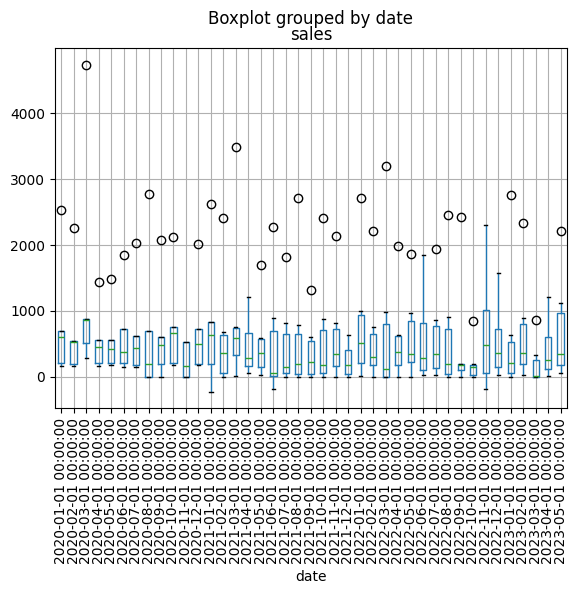

In [29]:
sales_data_without_outlier = sales_data.drop(sales_data[(sales_data['date'] == '2022-09-01') & (sales_data['product'] == 'c')].index)

# display(sales_data_without_outlier.groupby('date')['sales'].agg(['min', 'max', 'mean', 'std', 'median']).reset_index());
display(sales_data_without_outlier.boxplot(column=['sales'], by='date', rot=90))

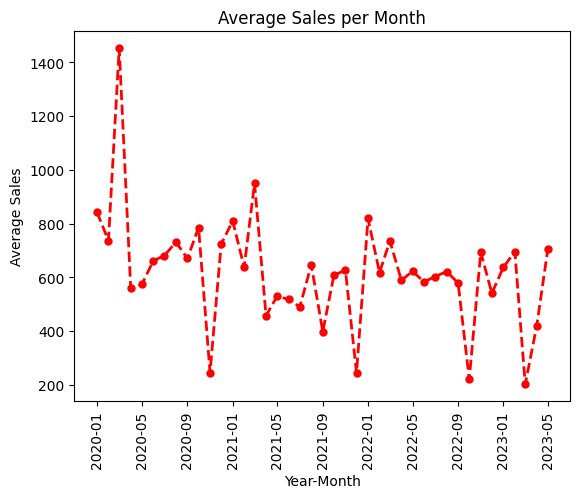

In [30]:
#plot the mean of the sales by date
data_sale = sales_data_without_outlier.groupby('date')['sales'].mean().sort_index(ascending=True)
plt.plot(data_sale, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.title('Average Sales per Month') 
plt.xlabel('Year-Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.show()

##### Average sales per product per month
Plotting without the data for product "c" in 09-2022, as its sales amount for this month-year was extremely high (suspiciously an outlier)

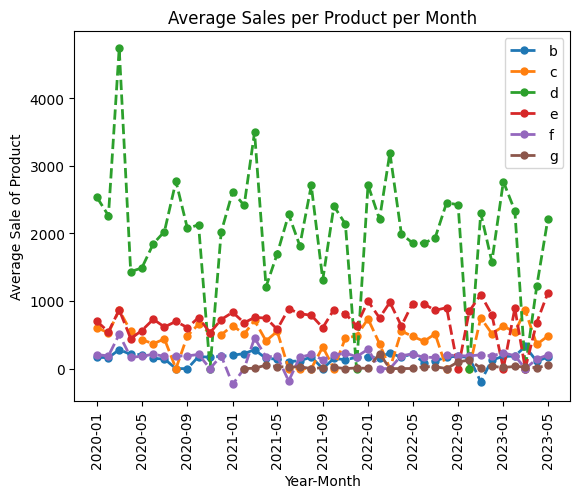

In [31]:
product_sale = sales_data_without_outlier.groupby(['date','product'])['sales'].mean().sort_index(ascending=True).unstack('product')

plt.plot(product_sale, marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.title('Average Sales per Product per Month') 
plt.xlabel('Year-Month')
plt.ylabel('Average Sale of Product')
plt.xticks(rotation=90)
plt.legend(product_sale.columns)
plt.show()

##### Effect of events on sales

In [32]:
events_data['Year_Month'] = pd.to_datetime(events_data['date']).dt.to_period('M')
# Get the start and end dates of each event:
aggregated_events = events_data.groupby(['event_name','Year_Month'])['date'].agg(['min', 'max']).reset_index()
aggregated_events

,event_name,Year_Month,min,max
0,CompetitorCampaign,2021-12,2021-12-05,2021-12-08
1,MediaCampaign,2020-04,2020-04-01,2020-04-06
2,ProductionShortage,2020-12,2020-12-15,2020-12-18
3,ProductionShortage,2022-12,2022-12-01,2022-12-04
4,SocialMediaCampaign,2022-06,2022-06-06,2022-06-11


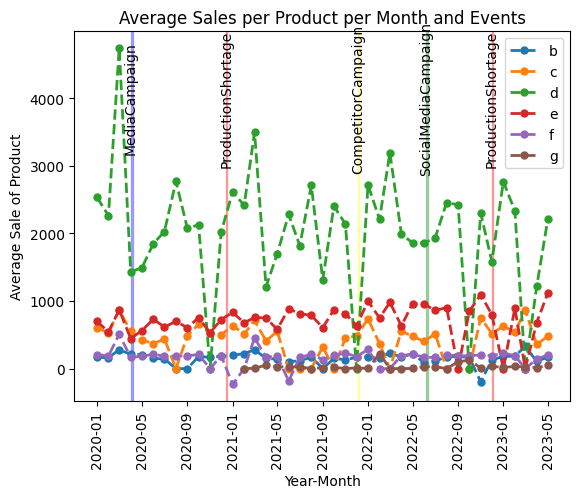

In [33]:
product_sale = sales_data_without_outlier.groupby(['date','product'])['sales'].mean().sort_index(ascending=True).unstack('product')

plt.plot(product_sale, marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.title('Average Sales per Product per Month and Events') 
plt.xlabel('Year-Month')
plt.ylabel('Average Sale of Product')
plt.xticks(rotation=90)
plt.legend(product_sale.columns)

# Add the event label for each event:
colors = {'CompetitorCampaign': 'yellow',
          'MediaCampaign': 'blue',
          'ProductionShortage': 'red',
          'SocialMediaCampaign': 'green',}

for event in aggregated_events.event_name.unique():
    event_df = aggregated_events[aggregated_events['event_name'] == event]
    color = colors[event]
    y_pos = 4000 
    event_label = event
    for index, row in event_df.iterrows():
        start_date = row['min']
        end_date = row['max']
        plt.axvspan(xmin=start_date, xmax=end_date, color=color, alpha=0.3)
        # Add a label for the event period
        x_pos = start_date
        plt.text(x_pos, y_pos, event_label, ha='center', va='center', color='black', rotation=90)
    
plt.show()

#### Comparison of sales between companies

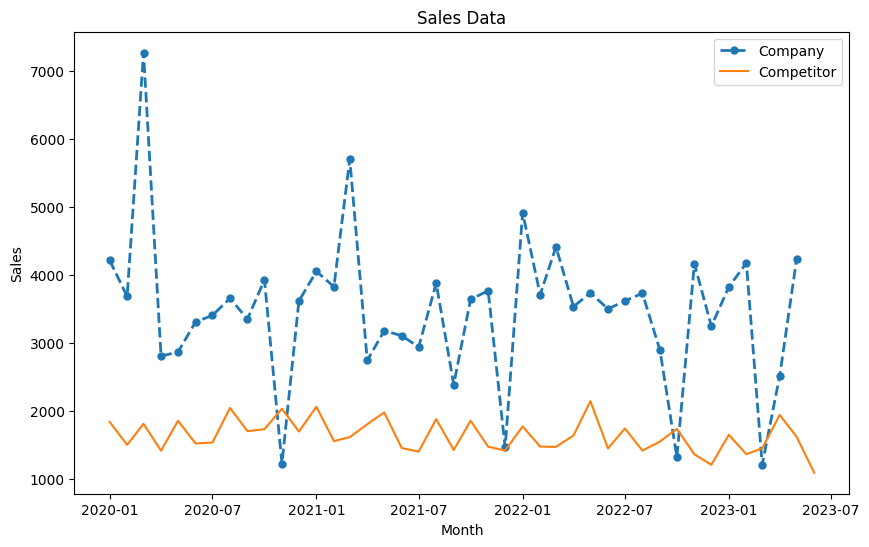

In [46]:
# All sales of the company:
month_sale = sales_data_without_outlier.groupby('date')['sales'].sum().sort_index(ascending=True)

# Plotting bar plot
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Plotting bars for company's sales
plt.plot(month_sale, marker='o', linestyle='dashed', linewidth=2, markersize=5)

# Plotting bars for competitor's sales
plt.plot(competitor_sales_data['date'], competitor_sales_data['sales'], label='Competitor')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales Data')
plt.legend(['Company', 'Competitor'])

plt.show()  # Display the plot

### A model to predict sales for next 6 months
Steps for the model creating:
First, I will use the data of holidays, events and 
1. Clean artifats and outliers, such as the very high sale of product c in 01-09-2022, negative values into zero
    
    1.1 Pay attention, product g only started to sell on 2021-02! 
2. split into train, validation sets (due to small amount of data, will split into 80-20, and run cross-validation)
3. build the model
4. validation

In [276]:
# Create a copy of the data for the model. The copy already filtered for the particular outlier of the very high sale rate of product c in 2022-09-01
data_for_model = sales_data_without_outlier.copy()

# Replace negative sale values into zero as there is not such thing as absolute negative sale amount:
data_for_model['sales'] = data_for_model['sales'] + 1e-8

# Sort the DataFrame by 'product' and 'date' columns
data_for_model.sort_values(['product', 'date'], inplace=True)



#### Prepare the data for model prediction

In [267]:
# Add data on holidays to the sales data:
holidays_data['Year_Month'] = pd.to_datetime(holidays_data['date']).dt.to_period('M')
holidays_dict = {
    'Passover I - Eve': 'Passover', 
    'Passover I': 'Passover', 
    'Passover - Chol HaMoed': 'Passover',
    'Passover VII - Eve': 'Passover', 
    'Passover VII': 'Passover', 
    'Memorial Day': 'Memorial_Day',
    'Independence Day': 'Independence_Day', 
    "Lag B'Omer": 'Lag_BOmer', 
    'Shavuot - Eve': 'Shavuot', 
    'Shavuot': 'Shavuot',
    'Rosh Hashanah - Eve': 'Rosh_Hashanah', 
    'Rosh Hashanah': 'Rosh_Hashanah', 
    'Yom Kippur - Eve': 'Yom_Kippur',
    'Yom Kippur': 'Yom_Kippur', 
    'Sukkot I - Eve': 'Sukkot', 
    'Sukkot I': 'Sukkot', 
    'Sukkot - Chol HaMoed': 'Sukkot',
    'Sukkot VII - Eve': 'Sukkot', 
    'Sukkot VII': 'Sukkot', 
    'Hanukkah': 'Hanukkah', 
    'Purim - Eve': 'Purim',
    'Purim': 'Purim', 
    'Shushan Purim': 'Purim', 
    'Memorial Day (Observed)': 'Memorial_Day',
    'Independence Day (Observed)': 'Independence_Day'
}

# Add a column to note the holiday in general:
holidays_data['holiday_name'] = holidays_data['holiday'].map(holidays_dict)
holidays_skinny = holidays_data[['holiday_name', 'Year_Month']].drop_duplicates()

# Merge the holidays into the data_for_model:
data_for_model_with_holidays = data_for_model.merge(holidays_skinny, how='left', on='Year_Month')
# data_for_model_with_holidays.holiday_name.fillna('No_holiday', inplace=True)

# Transform a column of holiday into binary 0/1 because some holidays happen together on the same month but the influence is whether there's a holiday+month,
# in order to avoid multiplying rows during merge where several holidays happen in the same month.
data_for_model_with_holidays['is_holiday'] = np.where(data_for_model_with_holidays['holiday_name'].isna(),0,1)
data_for_model_with_holidays.drop('holiday_name', axis=1, inplace=True)
data_for_model_with_holidays.drop_duplicates(inplace=True)
data_for_model_with_holidays

,product,sales,date,Year_Month,is_holiday
0,b,168.957105,2020-01-01,2020-01,0
1,b,159.948954,2020-02-01,2020-02,0
2,b,281.386973,2020-03-01,2020-03,1
3,b,209.969289,2020-04-01,2020-04,1
6,b,206.897521,2020-05-01,2020-05,1
...,...,...,...,...,...
310,g,17.601465,2023-01-01,2023-01,0
311,g,31.163690,2023-02-01,2023-02,0
312,g,24.950677,2023-03-01,2023-03,1
313,g,12.742655,2023-04-01,2023-04,1


In [269]:
# Add special events that happened during the data period:
events_skinny = events_data[['event_name','Year_Month']].drop_duplicates()
data_for_model_holidays_events = data_for_model_with_holidays.merge(events_skinny, how='left', on='Year_Month')

# Add competitors sales per month:
competitor_sales_data['Year_Month'] = pd.to_datetime(competitor_sales_data['date']).dt.to_period('M')
data_for_model_holidays_events_comp_sales = data_for_model_holidays_events.merge(
    competitor_sales_data[['sales', 'Year_Month']], how='left', on='Year_Month', suffixes=['', '_competitor'])
data_for_model_holidays_events_comp_sales

,product,sales,date,Year_Month,is_holiday,event_name,sales_competitor
0,b,168.957105,2020-01-01,2020-01,0,NaN,1842.608525
1,b,159.948954,2020-02-01,2020-02,0,NaN,1504.505509
2,b,281.386973,2020-03-01,2020-03,1,NaN,1813.601608
3,b,209.969289,2020-04-01,2020-04,1,MediaCampaign,1418.646377
4,b,206.897521,2020-05-01,2020-05,1,NaN,1858.345561
...,...,...,...,...,...,...,...
227,g,17.601465,2023-01-01,2023-01,0,NaN,1652.485753
228,g,31.163690,2023-02-01,2023-02,0,NaN,1367.627212
229,g,24.950677,2023-03-01,2023-03,1,NaN,1454.318394
230,g,12.742655,2023-04-01,2023-04,1,NaN,1944.910370


In [274]:
# Categorical transformation to the event_name column:
X = data_for_model_holidays_events_comp_sales

# Fill missing values with a specified value, such as 'Unknown'
X['event_name'] = X['event_name'].fillna('No_event')

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the categorical column
label_encoder.fit(X['event_name'])

# Transform the categorical column into numerical labels
X['event_label'] = label_encoder.transform(X['event_name'])

X.drop('event_name', axis=1, inplace=True)
X


,product,sales,date,Year_Month,is_holiday,sales_competitor,event_label
0,b,168.957105,2020-01-01,2020-01,0,1842.608525,2
1,b,159.948954,2020-02-01,2020-02,0,1504.505509,2
2,b,281.386973,2020-03-01,2020-03,1,1813.601608,2
3,b,209.969289,2020-04-01,2020-04,1,1418.646377,1
4,b,206.897521,2020-05-01,2020-05,1,1858.345561,2
...,...,...,...,...,...,...,...
227,g,17.601465,2023-01-01,2023-01,0,1652.485753,2
228,g,31.163690,2023-02-01,2023-02,0,1367.627212,2
229,g,24.950677,2023-03-01,2023-03,1,1454.318394,2
230,g,12.742655,2023-04-01,2023-04,1,1944.910370,2


#### Decomposition of data

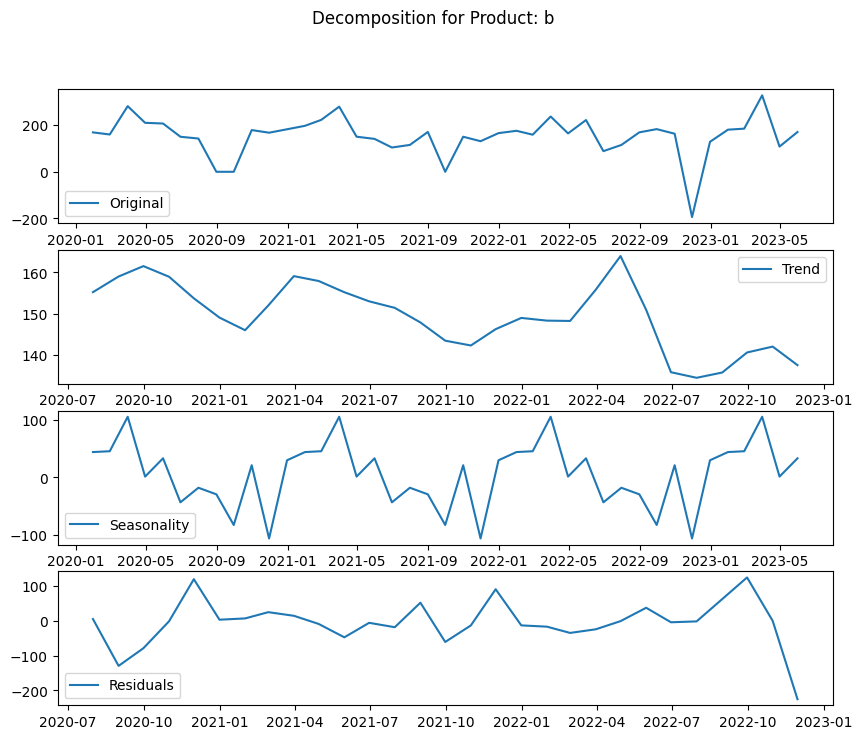

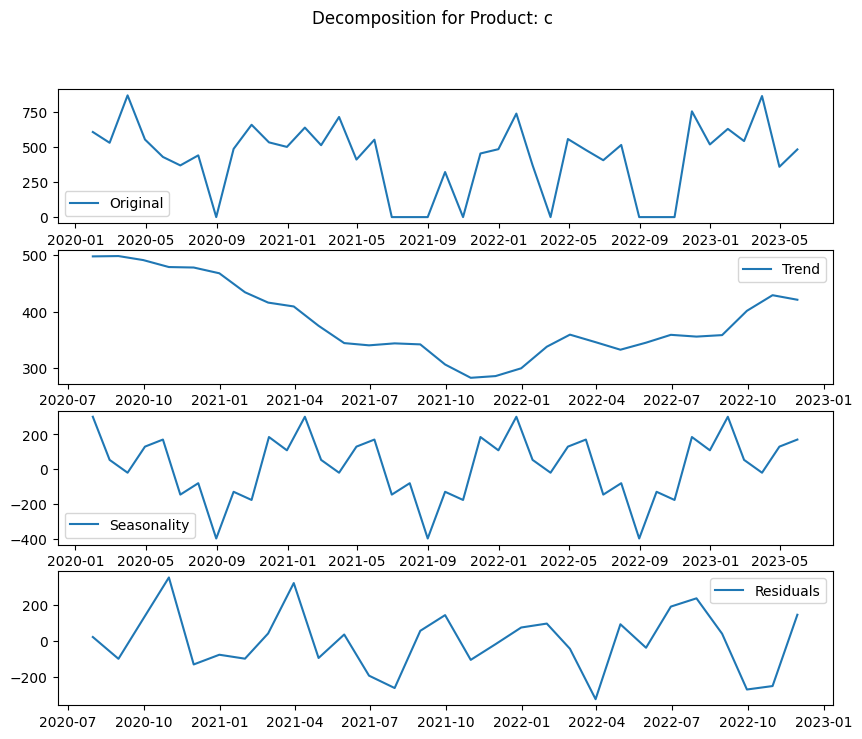

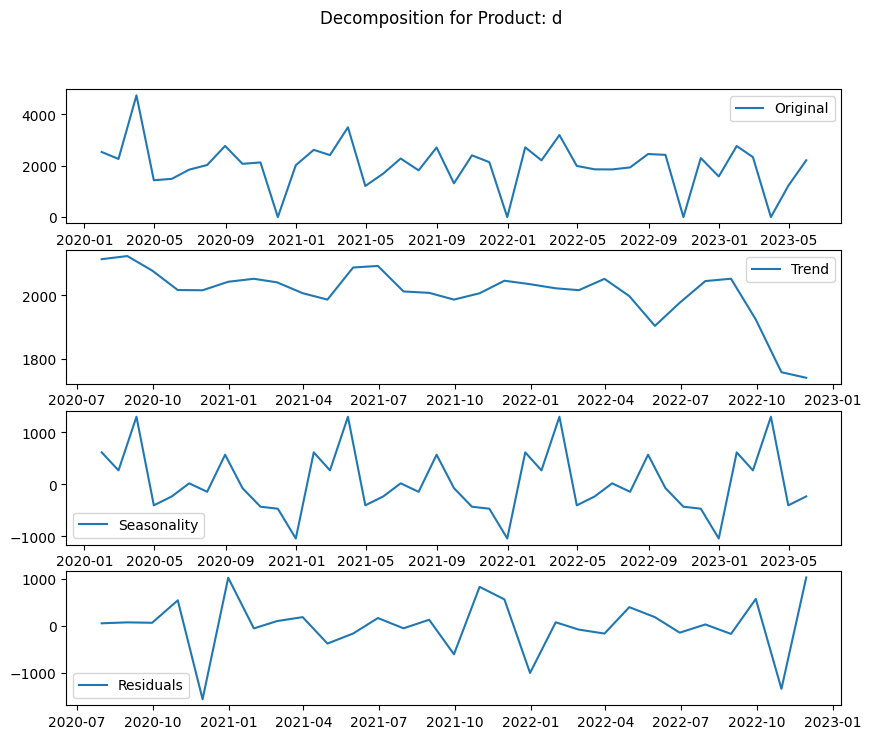

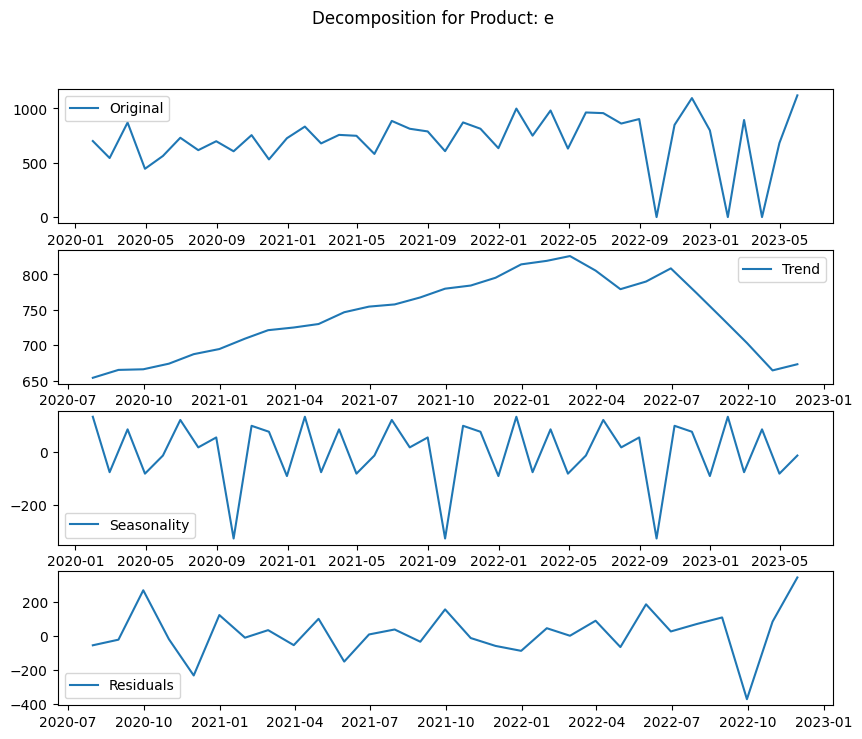

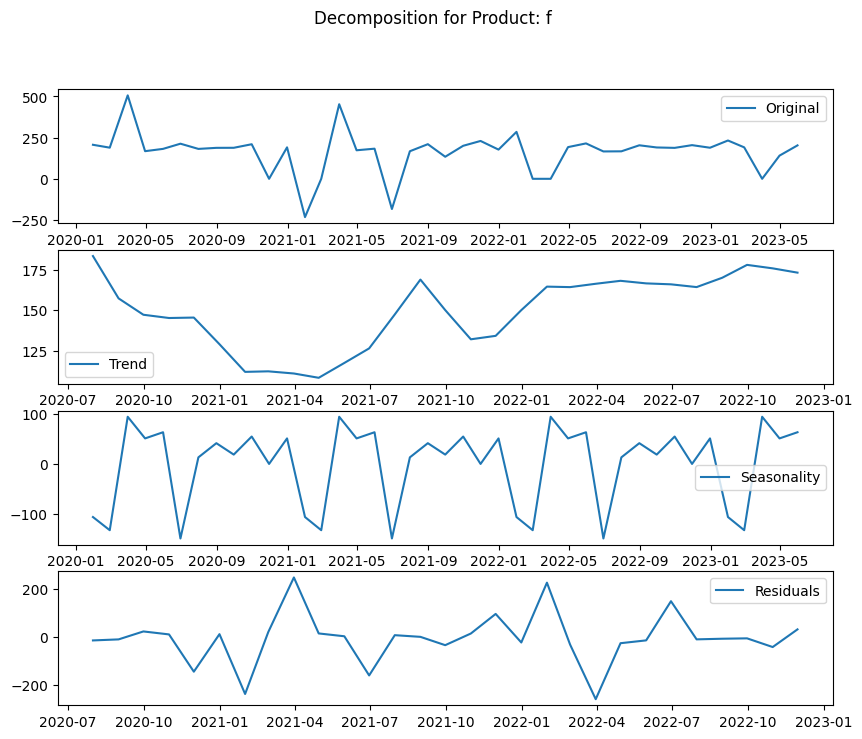

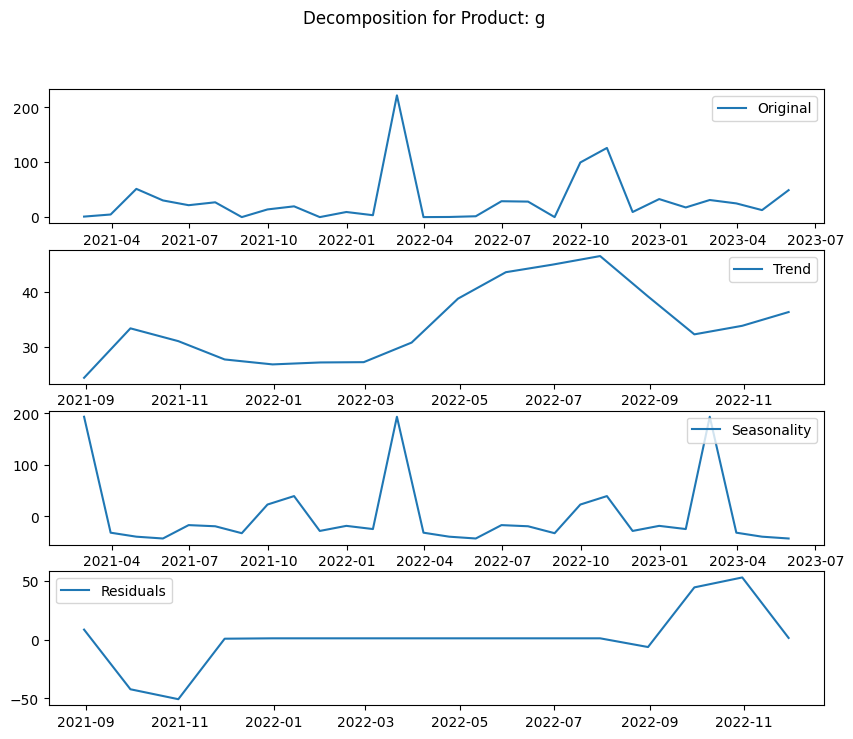

In [277]:
# Perform time series analysis separately for each product
for product, data in X.groupby('product'):
    # Set the 'date' column as the index for the product-specific data
    data.set_index('date', inplace=True)
    
    # Set the frequency of the index
    data = data.asfreq('D')
    
    # Resample the data to monthly frequency ('M') by taking the last observation of each month
    data = data.resample('M').last()
    
    # Interpolate missing values using linear interpolation
    data['sales'] = data['sales'].interpolate(method='linear')
    
    # Perform seasonal decomposition for the product-specific data
    decomposition = seasonal_decompose(data['sales'], model='additive')
    
    # Access the decomposed components for further analysis
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    print(product)
    print(len(trend) == len(seasonal))

    # Plot the decomposed components
    plt.figure(figsize=(10, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['sales'], label='Original')
    plt.legend(loc='best')
    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.suptitle(f'Decomposition for Product: {product}')
    plt.show()

In [300]:
for product, data in X.groupby('product'):
    # Set the 'date' column as the index for the product-specific data
    data.set_index('date', inplace=True)
    
    # Set the frequency of the index
    data = data.asfreq('D')
    
    # Resample the data to monthly frequency ('M') by taking the last observation of each month
    data = data.resample('M').last()
    
    # Interpolate missing values using linear interpolation
    data['sales'] = data['sales'].interpolate(method='linear')
    
    # Perform seasonal decomposition for the product-specific data
    decomposition = seasonal_decompose(data['sales'], model='additive')
    
    # Access the decomposed components for further analysis
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Reconstract the original time series:
    reconstructed_series = trend + seasonal

### Prediction loop over the products with the same parameters:
Clearly, not all product forcasting the same, so parameters should be tuned per each product.
Due to shortage in time, I showcase the process on product b (below).

In [ ]:
# Output file for documentation:
predictions_df = pd.DataFrame()

# Run one each product data and predict the last 6 months
for product, data in X.groupby('product'):
    prod_data = X[X['product'] == product]
    # Set the 'date' column as the index for the product-specific data
    prod_data.set_index('date', inplace=True)
    # Drop the product column:
    prod_data.drop('product', axis=1, inplace=True)
    # Leave the last 6 months for validation
    train_data = prod_data.iloc[:-6]
    val_data = prod_data.iloc[-6:]
    # Model params:
    p = 3
    q = 2
    d = 1

    model = ARIMA(train_data['sales'], order=(p, d, q))

    model_fit = model.fit()

    # Generate predictions
    predictions = model_fit.forecast(len(val_data))
    curr_df = pd.DataFrame(predictions)
    curr_df['product'] = product
    predictions_df = pd.concat([predictions_df, curr_df])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(val_data['sales'], predictions))
    print(f"RMSE for product {product}: {rmse}")

predictions_df
    

#### Output:

In [431]:
output_file = 'predictions_for_6_months.csv'
predictions_df.to_csv(os.path.join(folder_path, output_file))

#### Model the product b:

In [402]:
b = X[X['product'] == 'b']
# Set the 'date' column as the index for the product-specific data
b.set_index('date', inplace=True)

# Set the frequency of the index
b = b.asfreq('D')

# Resample the data to monthly frequency ('M') by taking the last observation of each month
b = b.resample('M').last()

# Interpolate missing values using linear interpolation
b['sales'] = b['sales'].interpolate(method='linear')

# Perform seasonal decomposition for the product-specific data
decomposition = seasonal_decompose(data['sales'], model='additive')

# Access the decomposed components for further analysis
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Reconstract the original time series:
reconstructed_series = trend + seasonal

In [417]:
# Drop the product column:
b.drop('product', axis=1, inplace=True)
# Leave the last 6 months for validation
train_data = b.iloc[:-6]
val_data = b.iloc[-6:]

#### Autocorrelation function (ACF) and partial autocorrelation function (PACF) plots
ACF suggests an autoregressive (AR) model (sharply drops)

PACF suggests an autoregressive (AR) model (sharply drops)

The lag at which the PACF cuts off corresponds to the order 'p' of the AR component is the first.


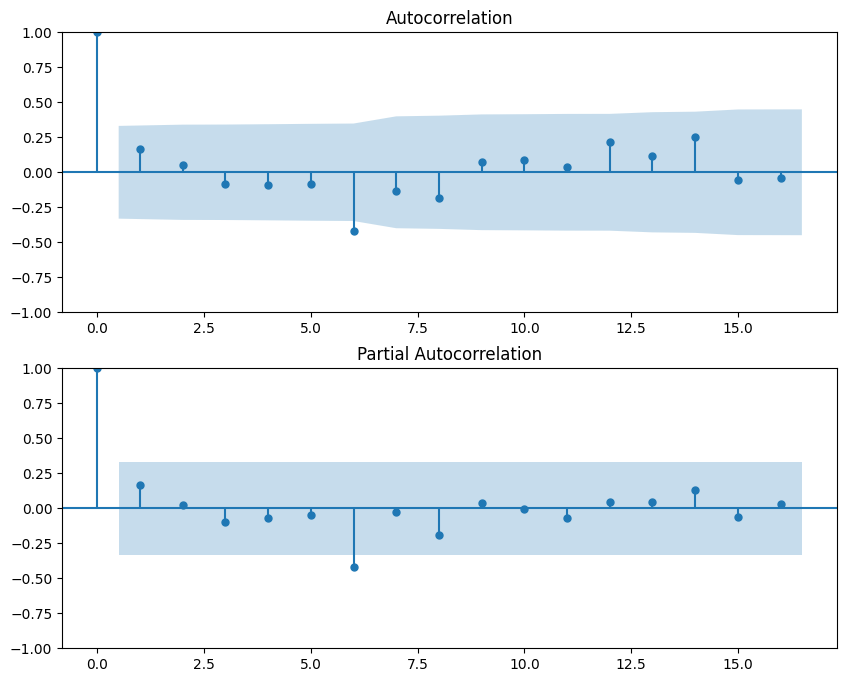

In [307]:

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_data['sales'], ax=ax1)
plot_pacf(train_data['sales'], ax=ax2)
plt.show()

#### Fit the ARIMA model

In [414]:
p = 3
q = 2
d = 1
# P = 3
# D = 1
# Q = 1  # Seasonal ARIMA parameters
# s = 4  # Seasonal period

model = ARIMA(train_data['sales'], order=(p, d, q))

# model = SARIMAX(train_data['sales'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

#### Predict

In [381]:
# Generate predictions
predictions = model_fit.forecast(len(val_data))

In [382]:
predictions

2022-12-31     99.650478
2023-01-31    129.609236
2023-02-28    229.432197
2023-03-31    240.617832
2023-04-30    231.182492
2023-05-31    191.049889
Freq: M, Name: predicted_mean, dtype: float64

#### Evaluate

In [365]:
val_data['sales']

date
2022-12-31    128.547848
2023-01-31    180.557378
2023-02-28    184.900326
2023-03-31    327.628751
2023-04-30    108.155090
2023-05-31    170.592176
Freq: M, Name: sales, dtype: float64

In [383]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(val_data['sales'], predictions))
print(f"RMSE: {rmse}")

RMSE: 68.96740598245765


#### Use all data of product b to predict the next 6 months:

In [422]:
# Specify the order (p, d, q) for the ARIMA model
order = (p, d, q)

# Fit the ARIMA model on the combined dataset
model = ARIMA(b['sales'], order=order)
model_fit = model.fit()

forecast_steps = 6  # the next 6 months to predict

# Generate the forecast
predictions = model_fit.forecast(steps=forecast_steps)
predictions

2023-06-30    146.159141
2023-07-31    152.770581
2023-08-31    155.253511
2023-09-30    150.512964
2023-10-31    155.120586
2023-11-30    151.793928
Freq: M, Name: predicted_mean, dtype: float64

## Answers to the questions in the doc:
5. a. Features that are important to the model:
    In this section, I would like to stress out that several features that I used, but didn't have the time to check, are features that I believe not available in the forecasting or may be randomly or semi-randomly appearing in the future, such as events (competitor campaign, shortages..).
    The most relevant data are the dates and whether there is a holiday. I also didn't have time to check whether the identity of the holiday affects the forecast more accurately than just the binary feature I designed. 

    b. I chose to use the ARIMA model for time series forecasting. 
    Pros of ARIMA model are:

        - largely-used by the community for time-series data.
        - can handle range of patterns, have the ability to incorporate trend, seasonality, and autocorrelation.
        - easy to use
    Cons of ARIMA model are:
    
        - assumes linear relationships and may miss nonlinear or highly complex patterns. 
        - sensitive to outliers
        - requires a sufficient amount of historical data to estimate the model parameters accurately. In this case, the data was very small.
        - not easy to set the appropriate p, d, q parameters, trial and error to get the best values.
    
    c. There are so many ways to improve the model. This is just a very fast script! First, there should be more data put into the model, feature engineering of the existing features, and even new features.
    I also could try a different approach and to use XGBoost or even linear regression, just to see how these models do on the current dataset.


Question 2:
1. Ways to dimentionality reduction:
- most commonly used is PCA, which transforms the original features into a new set of uncorrelated variables called principal components.
- similar to PCA: t-SNE, but in comparison to the linearity of PCA, tSNE is a non-linear approach.
- feature selection techniques which aim to select a subset of the original features that are most relevant to the prediction or analysis task (can also be done by Lasso)
3. 
a. The most important question to ask is whether the model accuracy is sufficient enough. Also, it is important to understand what kind of data the model will get in realtime, in order to train on the exact same features (avoid a situation where training is done on features that are not presented in a realtime data to predict on)

b. The steps to be taken when a model has to be deployed into production:
- create some API or a "contract" between the backend and the model (in terms of what type of data the model will get, and what type it returns).
- test the deployed model with known data that showcast many cases (also, if random seed is involved, it's important to fix it and document the seed.)
- when new data has to be added to retrain, repeat the former steps.

c. after a model is deployed, it has to be monitored constantly for accuracy, and performance.


